# LSTM Network using Raw+Flow
Using Recurrent neural network techniques, we trained our model to classify different types of activities performed by a person in a day. Our dataset was collected using a Mobile eye tracker from 10 persons.It consists of the gaze data recorded using eye camera and the scene data recorded using scene camera.We use a sampling frequency of 10 seconds for raw image and gaze data. Then, We generate the optical flow image using the raw images.

We split the data into 3 parts. 7 persons for training, 2 persons for testing, 1 person for validation

In this model, we use two different modalities of data such as raw image and optical flow image as input.

This model achieved a hamming loss of 0.2305 and predicted 9 different patterns

In [12]:
#import the required library functions
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense, Input, Dropout
from keras.layers.pooling import GlobalAveragePooling2D
from keras.layers.recurrent import LSTM
from keras.layers.wrappers import TimeDistributed
from keras.optimizers import Nadam
from keras.layers.merge import concatenate
from keras import regularizers
import keras
import numpy as np
import cv2
import tensorflow as tf
import pandas as pd
import h5py
from pathlib import Path
import matplotlib.pyplot as plt
from keras.layers.core import Reshape
import keras.backend as K
import datetime
import time
import telegram
from keras import metrics
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, Callback

# Callbacks

In [13]:
class TelegramCallback(Callback):

    def __init__(self, config):
        super(TelegramCallback, self).__init__()
        self.user_id = config['telegram_id']
        self.model_name = config['model_name']
        self.bot = telegram.Bot(config['token'])

    def send_message(self, text):
        try:
            self.bot.send_message(chat_id=self.user_id, text=text)
        except Exception as e:
            print('Message did not send. Error: {}.'.format(e))

    def on_train_begin(self, logs={}):
        text = 'Start training model {} | {}'.format(self.model.name, self.model_name)
        self.send_message(text)

    def on_epoch_end(self, epoch, logs={}):
        text = '{} | Epoch {}.\n'.format(self.model_name, epoch)
        for k, v in logs.items():
            text += '{}: {:.4f}; '.format(k, v)
        self.send_message(text)

In [14]:
class LoggingTensorBoard(TensorBoard):    

    def __init__(self, log_dir, settings_str_to_log, **kwargs):
        super(LoggingTensorBoard, self).__init__(log_dir, **kwargs)

        self.settings_str = settings_str_to_log

    def on_train_begin(self, logs=None):
        TensorBoard.on_train_begin(self, logs=logs)

# Preparing training and test set

In [8]:
HDF5_PATH = '/home/gururajaramesh/completedata_withP10.hdf5'

In [9]:
hdf=h5py.File(HDF5_PATH,'r')

In [11]:
train_x1 = hdf["train/rawImages"]
train_x2 = hdf["train/flowImages"]
train_x3 = hdf["train/gazeData"]
train_y = hdf["train/labels"]


test_x1 = hdf["test/rawImages"]
test_x2 = hdf["test/flowImages"]
test_x3 = hdf["test/gazeData"]
test_y = hdf["test/labels"]

val_x1 = hdf["validation/rawImages"]
val_x2 = hdf["validation/flowImages"]
val_x3 = hdf["validation/gazeData"]
val_y = hdf["validation/labels"]

print(train_x1.shape, train_x2.shape, train_x3.shape, train_y.shape)
print(test_x1.shape, test_x2.shape, test_x3.shape, test_y.shape)
print(val_x1.shape, val_x2.shape, val_x3.shape, val_y.shape)

(17884, 224, 224, 3) (17884, 224, 224, 3) (17884, 60) (17884, 9)
(4665, 224, 224, 3) (4665, 224, 224, 3) (4665, 60) (4665, 9)
(1381, 224, 224, 3) (1381, 224, 224, 3) (1381, 60) (1381, 9)


# Training

In [12]:
def myGenerator(set_name, batch_size):
    """
    This generator returns normalized capacitive images (0..1) and the respective labels in mm.
    """
    hdf = h5py.File(HDF5_PATH, "r")

    pRawImages = hdf[set_name + "/rawImages"]
    pFlowImages = hdf[set_name + "/flowImages"]
    pLabels = hdf[set_name + "/labels"]

    len_train = pRawImages.shape[0]
    
    randomBatchOrder = list(range(len_train-timesteps))
       
    while True:
        np.random.shuffle(randomBatchOrder) 
        
        for i in range(0, (len_train // (batch_size))-1):
            frames = []
            flow = []
            labels = []
            for j in range (batch_size):
                idx = randomBatchOrder[i*batch_size+j]
                shuffled1 = pRawImages[idx : idx+timesteps]
                frames.append(shuffled1)
                shuffled2 = pFlowImages[idx : idx+timesteps]
                flow.append(shuffled2)
                shuffled4 = pLabels[idx+timesteps]
                labels.append(shuffled4)

            yield [np.array(frames).reshape(-1,timesteps,224,224,3)/256, np.array(flow).reshape(-1,timesteps,224,224,3)/256], np.array(labels).reshape(-1,9)


In [13]:
batch_size = 10
classes = 9 

#no.of.epochs
epochs = 150

# input image dimensions
timesteps, rows, columns, channels = 5, 224, 224, 3

In [19]:
#custom loss function for Multilabel Classification
def multitask_loss(y_true, y_pred):
    # Avoid divide by 0
    y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
    # Multi-task loss
    return K.mean(K.sum(- y_true * K.log(y_pred) - (1 - y_true) * K.log(1 - y_pred), axis=1))

In [ ]:
with tf.device('/device:GPU:0'):
    config = tf.ConfigProto(log_device_placement = True, allow_soft_placement = True)
    config.gpu_options.allow_growth=True
    config.gpu_options.per_process_gpu_memory_fraction = 0.5
    config.gpu_options.allocator_type = 'BFC'
    
    with tf.Session(config=config):
        tf.get_default_graph()
        #First VGG16 model for Raw RGB Image 
        RGB_Image = Input(shape=(timesteps, rows, columns, channels))

        cnn_base = VGG16(input_shape=(rows,columns,channels), weights="imagenet", include_top=False)

        cnn_out = GlobalAveragePooling2D()(cnn_base.output)
        cnn = Model(inputs=cnn_base.input, outputs=cnn_out)
        for layer in cnn.layers:
            layer.trainable=False

        encoded_frames1 = TimeDistributed(cnn)(RGB_Image)


        #second VGG16 model for Optical Flow Image 
        Flow_Image = Input(shape=(timesteps, rows,columns,channels))
        cnn_flow = VGG16(input_shape=(rows,columns,channels), weights="imagenet", include_top=False)
        cnn_out2 = GlobalAveragePooling2D()(cnn_flow.output)

        cnn2 = Model(input=cnn_flow.input, output=cnn_out2)
        for layer in cnn2.layers:
            layer.trainable=False

        encoded_frames2 = TimeDistributed(cnn2)(Flow_Image)

        #Concatenate the features from the two different modalities
        merge = concatenate([encoded_frames1, encoded_frames2])

        #Concatenated features are feed to the backend LSTM model for final activity prediction
        encoded_sequence = LSTM(64)(merge)
        encoded_sequence = Dropout(0.3)(encoded_sequence)
        hidden_layer1 = Dense(output_dim=200, activation="relu")(encoded_sequence)
        hidden_layer1 = Dropout(0.5)(hidden_layer1)
        hidden_layer2 = Dense(output_dim=100, activation="relu")(hidden_layer1)
        hidden_layer2 = Dropout(0.5)(hidden_layer2)
        outputs = Dense(output_dim=classes, activation="sigmoid")(hidden_layer2)
        model = Model([RGB_Image, Flow_Image], outputs, name ='RAW+FLOW_v01_Adam+LSTM8+D32+LSTM64+D100+Sigmoid')
        model.summary()

        #Optimizer for the Neural Network
        optimizer = keras.optimizers.Adam(lr=0.0001)
        
        #create the tensorboard file
        readable_timestamp = datetime.datetime.fromtimestamp(time.time()).strftime('%Y%m%d_%H%M%S')
        file_name = "RAW+FLOW_v01_Adam+LSTM8+D32+LSTM64+D200+D100+Sigmoid+NoSlidingWindow_" + readable_timestamp
        print(file_name)
        tensorboardFolder = "/home/gururajaramesh/tensorboardfiles/" + file_name
        
        # create callback
        config = {
            'token': '751130989:AAGKiP8ibYbR6CoXHz6eXE8mR2vcYO57dwM',   # paste your bot token
            'telegram_id': 752166506,                                   # paste your telegram_id
            'model_name': file_name,
        }

        #callback for Telegram
        tg_callback = TelegramCallback(config)
        
        #callback for Tensorboard
        tb_callback = LoggingTensorBoard(settings_str_to_log=config,
                           log_dir=tensorboardFolder,
                           histogram_freq=0,
                           write_graph=True,
                           write_images=True,
                           update_freq='epoch'
                          )
        
        #callback for Model Check Point
        sm_callback = ModelCheckpoint(str(Path.home()) + "/models/"+ file_name + ".{epoch:04d}-{val_loss:.2f}.h5",
                            monitor='val_acc',
                            verbose=0,
                            save_best_only=True,
                            save_weights_only=False
                           )
        
        #compile the model
        model.compile(loss=multitask_loss,
                      optimizer=optimizer,
                      metrics=["acc"]) 

        #fit the compiled model
        history = model.fit_generator(myGenerator("train", batch_size),
                    steps_per_epoch=len(train_x1) // (batch_size*timesteps),
                    epochs=epochs,callbacks = [tg_callback, tb_callback, sm_callback],
                    verbose=1,
                    validation_data=myGenerator("test", batch_size),
                    validation_steps=len(test_x1) // (batch_size*timesteps))
        
        #predict using the trained model with the validation data
        result = model.predict_generator(myGenerator("validation", batch_size), steps=len(val_x1) // batch_size)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("gl...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=200)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:48: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=100)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="sigmoid", units=9)`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 5, 224, 224,  0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            (None, 5, 224, 224,  0                                            
__________________________________________________________________________________________________
time_distributed_3 (TimeDistrib (None, 5, 512)       14714688    input_5[0][0]                    
__________________________________________________________________________________________________
time_distributed_4 (TimeDistrib (None, 5, 512)       14714688    input_7[0][0]                    
__________________________________________________________________________________________________
concatenat

In [ ]:
#plot for Training vs Test Accuracy
plt.plot(history.history['val_acc'], label="Test Accuracy")
plt.plot(history.history['acc'], label="Training Accuracy")
plt.legend()
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Test Accuracy')

In [ ]:
#plot for Training vs Test Loss
plt.plot(history.history['val_loss'], label="Test Loss")
plt.plot(history.history['loss'], label="Training Loss")
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Training vs Test Loss')

# Results

In [35]:
#obtain predicted output in terms of one hot coding
y_predict = np.copy(result)
y_predict[y_predict>0.5]=1
y_predict[y_predict<0.5]=0

In [37]:
y_true = np.load('/home/gururajaramesh/P10data/LabelsP10.npy')
print(y_true.shape)
y_true = y_true.reshape(-1,9)
print(y_true.shape)
y_true1= y_true[0:1380,:]
print(y_true1.shape)
y_true[1:10]

(1381, 1, 9)
(1381, 9)
(1380, 9)


array([[0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 1, 0, 1, 0, 1, 0, 0],
       [0, 0, 1, 0, 1, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0, 0, 0,

In [38]:
import sklearn

#Classfication report for the predicted output
print ('\n Summary of the precision, recall, F1 score for each class:')
print (sklearn.metrics.classification_report(y_true1, y_predict))


 Summary of the precision, recall, F1 score for each class:
             precision    recall  f1-score   support

          0       0.00      0.00      0.00        87
          1       0.19      0.16      0.17       249
          2       0.54      0.26      0.35       803
          3       0.00      0.00      0.00        79
          4       0.62      0.33      0.43       897
          5       0.10      0.11      0.11       121
          6       0.11      0.01      0.02       202
          7       0.00      0.00      0.00       136
          8       0.07      0.03      0.04       128

avg / total       0.40      0.21      0.27      2702



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [39]:
#Hamming loss of the predicted output
print ('Hamming Loss: ')
print(sklearn.metrics.hamming_loss(y_true1, y_predict))

Hamming Loss: 
0.23051529790660225


In [46]:
#to find the number of different patterns in the predicted output
y_true = np.copy(y_predict)
firsttime = True
patternlist = []
countlist = []
for i in range(y_true.shape[0]):
    if(firsttime):
        curr_pattern = y_true[0,:]
        print('Found new pattern : %s' % curr_pattern)
        patternlist.append(curr_pattern)
        count = 0
        for j in range(y_true.shape[0]):
            #check if the pattern is same as the curr.pattern and increase count if not continue
            if(np.array_equal(curr_pattern, y_true[j,:])):
                count =  count + 1
            else:
                continue
        countlist.append(count)
        firsttime = False
        print('%s pattern found %s times' % (curr_pattern, count))
    else:
        curr_pattern = y_true[i,:]
        new_pattern = False
        already_present= False
        #check if curr_pattern is in patternlist
        for k in range(len(patternlist)):
            if(np.array_equal(curr_pattern, patternlist[k])):
                already_present = True
                break
            else:
                continue
        if(already_present):
            new_pattern = False
        else:
            new_pattern = True
        #if it is a new pattern  then count its occurance    
        if(new_pattern):
            print('Found new pattern : %s' % curr_pattern)
            patternlist.append(curr_pattern)
            count = 0
            for j in range(y_true.shape[0]):
                if(np.array_equal(curr_pattern, y_true[j,:])):
                    count = count + 1
                else:
                    continue
            countlist.append(count)
            print('%s pattern found %s times' % (curr_pattern, count))        

Found new pattern : [0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0.] pattern found 607 times
Found new pattern : [0. 0. 1. 0. 1. 0. 0. 0. 0.]
[0. 0. 1. 0. 1. 0. 0. 0. 0.] pattern found 264 times
Found new pattern : [0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 0. 0.] pattern found 212 times
Found new pattern : [0. 0. 0. 0. 1. 0. 0. 0. 0.]
[0. 0. 0. 0. 1. 0. 0. 0. 0.] pattern found 89 times
Found new pattern : [0. 0. 1. 0. 1. 1. 0. 0. 0.]
[0. 0. 1. 0. 1. 1. 0. 0. 0.] pattern found 121 times
Found new pattern : [0. 0. 0. 0. 0. 0. 0. 0. 1.]
[0. 0. 0. 0. 0. 0. 0. 0. 1.] pattern found 56 times
Found new pattern : [0. 0. 0. 1. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0.] pattern found 7 times
Found new pattern : [0. 0. 0. 0. 0. 0. 1. 0. 0.]
[0. 0. 0. 0. 0. 0. 1. 0. 0.] pattern found 18 times
Found new pattern : [1. 0. 0. 1. 0. 0. 0. 0. 0.]
[1. 0. 0. 1. 0. 0. 0. 0. 0.] pattern found 3 times
Found new pattern : [0. 0. 0. 0. 1. 1. 0. 0. 0.]
[0. 0. 0. 0. 1. 1. 0. 0. 0.] pattern fou

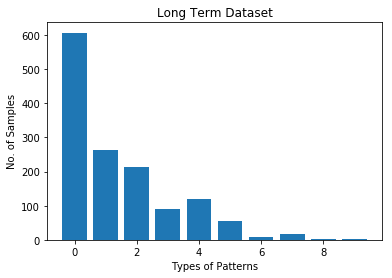

In [50]:
#plot the No.of Samples vs Types of patters
x1 = list(range(len(countlist)))
plt.bar(x1, countlist)
plt.xlabel('Types of Patterns', fontsize=10)
plt.ylabel('No. of Samples', fontsize=10)
plt.title('Long Term Dataset')
plt.show()

In [ ]:
#close the HDF5 file
hdf.close()

In [ ]:
#save the trained model as HDF5 file
model.save("Raw+Flow_Adam.h5")